In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from time import time
import os


# %matplotlib inline
# %load_ext autoreload
# %autoreload 

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# torch.cuda.current_device()

In [3]:
# train_x = torch.stack([torch.linspace(0, 1, 100),
# torch.linspace(0, 2, 100)
# ],-1)
# train_x1 = torch.linspace(0, 1, 100)

# print(0)
# train_y = torch.stack([
#     torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     torch.sin(train_x1 * (2 * math.pi)) + 2 * torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
#     -torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
# ], -1)

# print(train_x.shape, train_y.shape)

In [4]:
def return_data(fold,month,with_scaling, station_id = None):
    train_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_train_'+month+'.csv.gz')
    test_input = pd.read_csv('AAAI22/data/processed'+'/fold_'+str(fold)+'_test_'+month+'.csv.gz')
    if station_id != None:
        test_input = test_input[test_input['station_id'] == station_id]
    test_output = np.concatenate((np.array(test_input['PM25_Concentration']).reshape(-1,1), np.array(test_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_output = np.concatenate((np.array(train_input['PM25_Concentration']).reshape(-1,1), np.array(train_input['CO_Concentration']).reshape(-1,1)), axis=1)
    train_input= train_input.drop(['station_id','PM25_Concentration','CO_Concentration','time','filled'],axis=1)
    try:
        test_input= test_input.drop(['PM25_Concentration','CO_Concentration','station_id','time','filled'],axis=1)
    except:
        test_input= test_input.drop(['station_id','time','filled'],axis=1)
    if with_scaling:
        scaler_x = MinMaxScaler()
        scaler_y = StandardScaler()
        scaler_y1 = StandardScaler()
        # scaler = MinMaxScaler().fit(train_input)
        # train_input = pd.DataFrame(scaler_x.fit_transform(train_input),columns=list(train_input.columns))
        # train_output = scaler_y.fit_transform(train_output)
        # test_input = pd.DataFrame(scaler_x.transform(test_input),columns=list(test_input.columns))
        # scaler = MinMaxScaler().fit(train_input)
        train_input = torch.tensor(scaler_x.fit_transform(train_input)).to(torch.float32)
        test_input = torch.tensor(scaler_x.transform(test_input)).to(torch.float32)
        train_output[:,0] = torch.tensor(scaler_y.fit_transform(train_output[:,0].reshape(-1,1)).reshape(-1,)).to(torch.float32)
        # print(train_output.shape)
        train_output[:,1] = torch.tensor(scaler_y1.fit_transform(train_output[:,1].reshape(-1,1)).reshape(-1,)).to(torch.float32)
        # print(train_output.shape)
        test_output = torch.tensor(test_output).to(torch.float32)
    return train_input, torch.tensor(train_output).to(torch.float32),test_input,test_output, scaler_y, scaler_y1
       
    #     scaler_y = StandardScaler()
    #     # scaler = MinMaxScaler().fit(train_input)
    #     # train_input = pd.DataFrame(scaler_x.fit_transform(train_input),columns=list(train_input.columns))
    #     # train_output = scaler_y.fit_transform(train_output)
    #     # test_input = pd.DataFrame(scaler_x.transform(test_input),columns=list(test_input.columns))
    #     # scaler = MinMaxScaler().fit(train_input)
    #     train_input = torch.tensor(scaler_x.fit_transform(train_input)).to(torch.float32)
    #     test_input = torch.tensor(scaler_x.transform(test_input)).to(torch.float32)
    #     train_output = torch.tensor(scaler_y.fit_transform(train_output)).to(torch.float32)
    #     test_output = torch.tensor(test_output).to(torch.float32)
    # return train_input,train_output,test_input,test_output, scaler_y

In [5]:
for fold in [0]:
    train_input,train_output,test_input,test_output,scaler_pm, scaler_co = return_data(fold=fold,month='mar',with_scaling=True)
    print("Fold: ",fold)
    print("Data received")

Fold:  0
Data received


In [6]:
train_input.shape,train_output.shape,test_input.shape,test_output.shape, train_input.type(), train_output.type()

(torch.Size([166440, 5]),
 torch.Size([166440, 2]),
 torch.Size([87600, 5]),
 torch.Size([87600, 2]),
 'torch.FloatTensor',
 'torch.FloatTensor')

In [7]:
mean_train1 = np.array(np.repeat(train_output[:,0].mean(), train_input.shape[0])).reshape(-1,1)
mean_train2 = np.array(np.repeat(train_output[:,1].mean(), train_input.shape[0])).reshape(-1,1)
mean_train = torch.tensor(np.concatenate((mean_train1, mean_train2), 1)).to(torch.float32)
mean_train.shape

torch.Size([166440, 2])

In [13]:
num_latents = 1
num_tasks = 2

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 1000, 5)
        print(inducing_points.shape)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=2,
            num_latents=1,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.mean_module.initialize(constant=0.)
        self.mean_module.constant.requires_grad = False

        # self.covar_module = gpytorch.kernels.ScaleKernel((
        #     gpytorch.kernels.MaternKernel(nu= 1.5, batch_shape=torch.Size([num_latents]), ARD=train_input.shape[1]) + 
        #     gpytorch.kernels.MaternKernel(nu= 1.5, batch_shape=torch.Size([num_latents]), ARD=train_input.shape[1])*
        #     gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents]), ARD=train_input.shape[1])),
        #     batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel( batch_shape=torch.Size([num_latents]), ard_num_dims=train_input.shape[1]),
            batch_shape=torch.Size([num_latents]))
    
    


    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
      
        # print(0)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel().to("cuda:3")
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to("cuda:3")
#.to("cuda:1")
# .to("cuda:1")


torch.Size([1, 1000, 5])


In [14]:
# likelihood(model(train_input[:10000,:])).rsample().shape

In [15]:
# class IndependentMultitaskGPModel(gpytorch.models.ApproximateGP):
#     def __init__(self):
#         # Let's use a different set of inducing points for each task
#         inducing_points = torch.rand(num_tasks, 16, 1)

#         # We have to mark the CholeskyVariationalDistribution as batch
#         # so that we learn a variational distribution for each task
#         variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
#         )

#         variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
#             gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, variational_distribution, learn_inducing_locations=True
#             ),
#             num_tasks=2,
#         )

#         super().__init__(variational_strategy)

#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
#         self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_tasks])),
#             batch_shape=torch.Size([num_tasks])
#         )

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# output = model(train_x)
# print(output.__class__.__name__, output.event_shape)

In [17]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 300

points = 20000

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_output[:points,:].to("cuda:3").size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
loss_arr = []
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(train_input[:points,:].to("cuda:3"))
    loss = -mll(output, mean_train[:points,:].to("cuda:3"))
    loss_arr.append(loss.detach().cpu())
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/tmp/ipykernel_1852546/3034990469.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [18]:
model.mean_module.constant

Parameter containing:
tensor([[0.]], device='cuda:3')

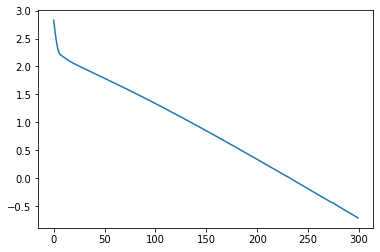

In [19]:
plt.plot(loss_arr)

In [20]:
# Set into eval mode
model.eval()
likelihood.eval()
test_points = 10000
# Initialize plots
# fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.stack([ torch.linspace(0, 1, 51),
    # torch.linspace(0, 2, 51)],-1)
    # print(test_input[:3000,:].shape)
    predictions = likelihood(model(test_input[:test_points,:].to("cuda:3")))


In [21]:
mean = np.array(predictions.mean.cpu())

In [22]:
mean[:,0] = scaler_pm.inverse_transform(np.array(mean[:,0]).reshape(-1,1)).reshape(-1,)
mean[:,1] = scaler_co.inverse_transform(mean[:,1].reshape(-1,1)).reshape(-1,)
lower, upper = predictions.confidence_region()

In [23]:
mean = np.clip(mean, 0, mean.max(), out=mean)

In [24]:
mean.shape

(10000, 2)

In [25]:
mean_test1 = np.array(np.repeat(test_output[:,0].mean(), test_input.shape[0])).reshape(-1,1)
mean_test2 = np.array(np.repeat(test_output[:,1].mean(), test_input.shape[0])).reshape(-1,1)
mean_test = torch.tensor(np.concatenate((mean_test1, mean_test2), 1)).to(torch.float32)
mean_test.shape

torch.Size([87600, 2])

In [31]:
print('Test MAE PM: {}'.format(torch.mean(torch.abs(torch.tensor(mean[:,0]) - test_output[:10000,0]))))
print('Test MAE CO: {}'.format(torch.mean(torch.abs(torch.tensor(mean[:,1]) - test_output[:10000,1]))))

Test MAE PM: 53.004981994628906
Test MAE CO: 0.6838937401771545


In [27]:
# # 31.924883, 30.815863
# err1 = mean_squared_error(mean[:,0], test_output[:test_points,0], squared=False)
# err2 = mean_squared_error(mean[:,1], test_output[:test_points,1], squared=False)
# print(print(f"RMSE: {err1}"))
# print(print(f"RMSE: {err2}"))


In [28]:
#scalere_y mean and variance

Text(0.5, 1.0, 'MOGP')

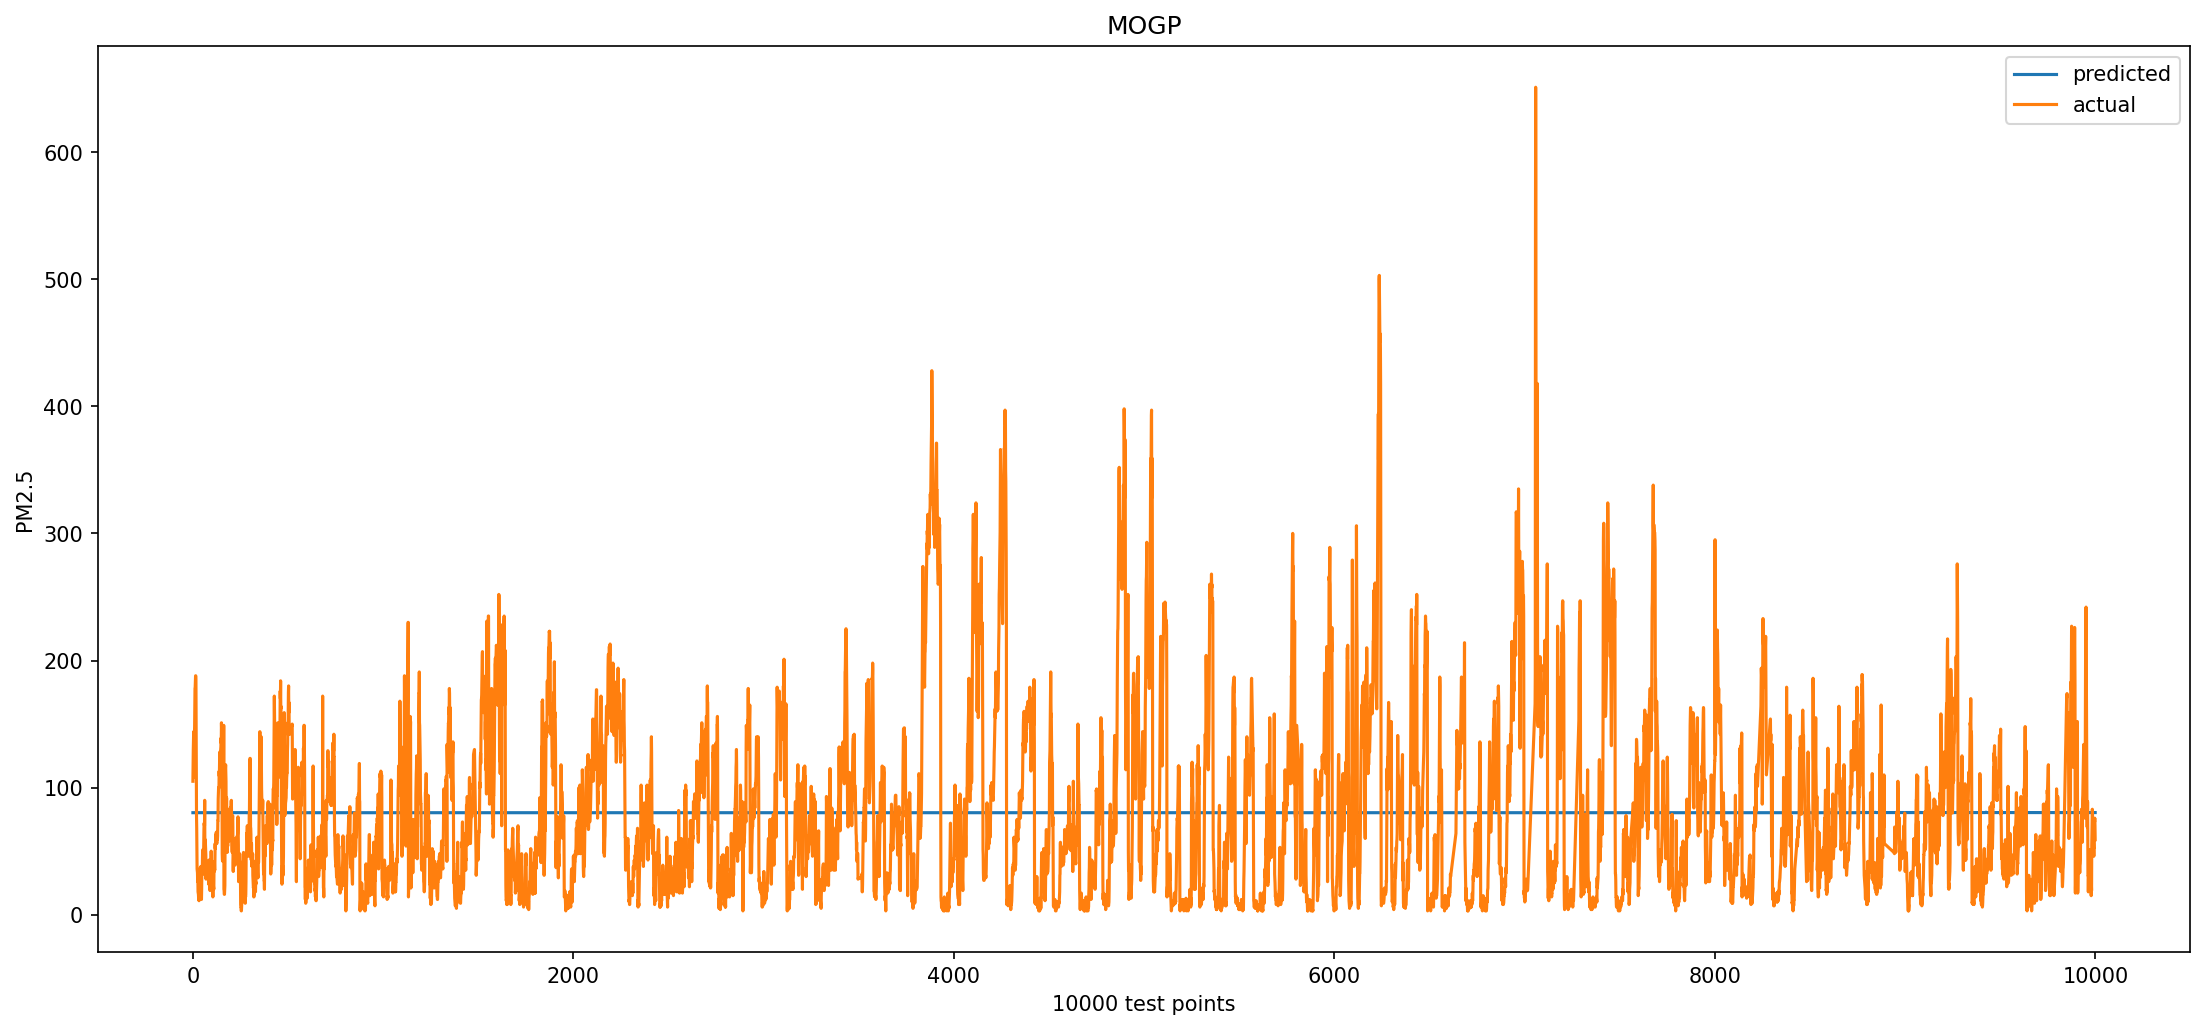

In [32]:
# preds_stds = np.sqrt(scaler_y.inverse_transform(predictions.variance.detach().cpu()))
# preds_mean = scaler_y.inverse_transform(predictions.mean.detach().cpu())
# preds_mean = preds_mean
# preds_stds = preds_stds
# lower_line = preds_mean - 2 * preds_stds
# upper_line = preds_mean + 2 * preds_stds

# print(preds_mean.shape, preds_stds.shape)

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
# plt.fill_between(
#     range(len(test_output[:test_points,:])),
#     lower_line[:,0],
#     upper_line[:,0],
#     facecolor="gray",
#     alpha=0.5,
#     label=r"95% confidence",
# )
plt.plot(mean[:,0], label=r"predicted", linewidth=1.5)
# y_test = test_output[:5000,:]
plt.plot(test_output[:test_points,0], label=r"actual", linewidth=1.5)
plt.ylabel("PM2.5")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "MOGP"
)
# plt.savefig(f"deep_variational_station_1006_{i}.png")
# model.train()

# %

Text(0.5, 1.0, 'MOGP')

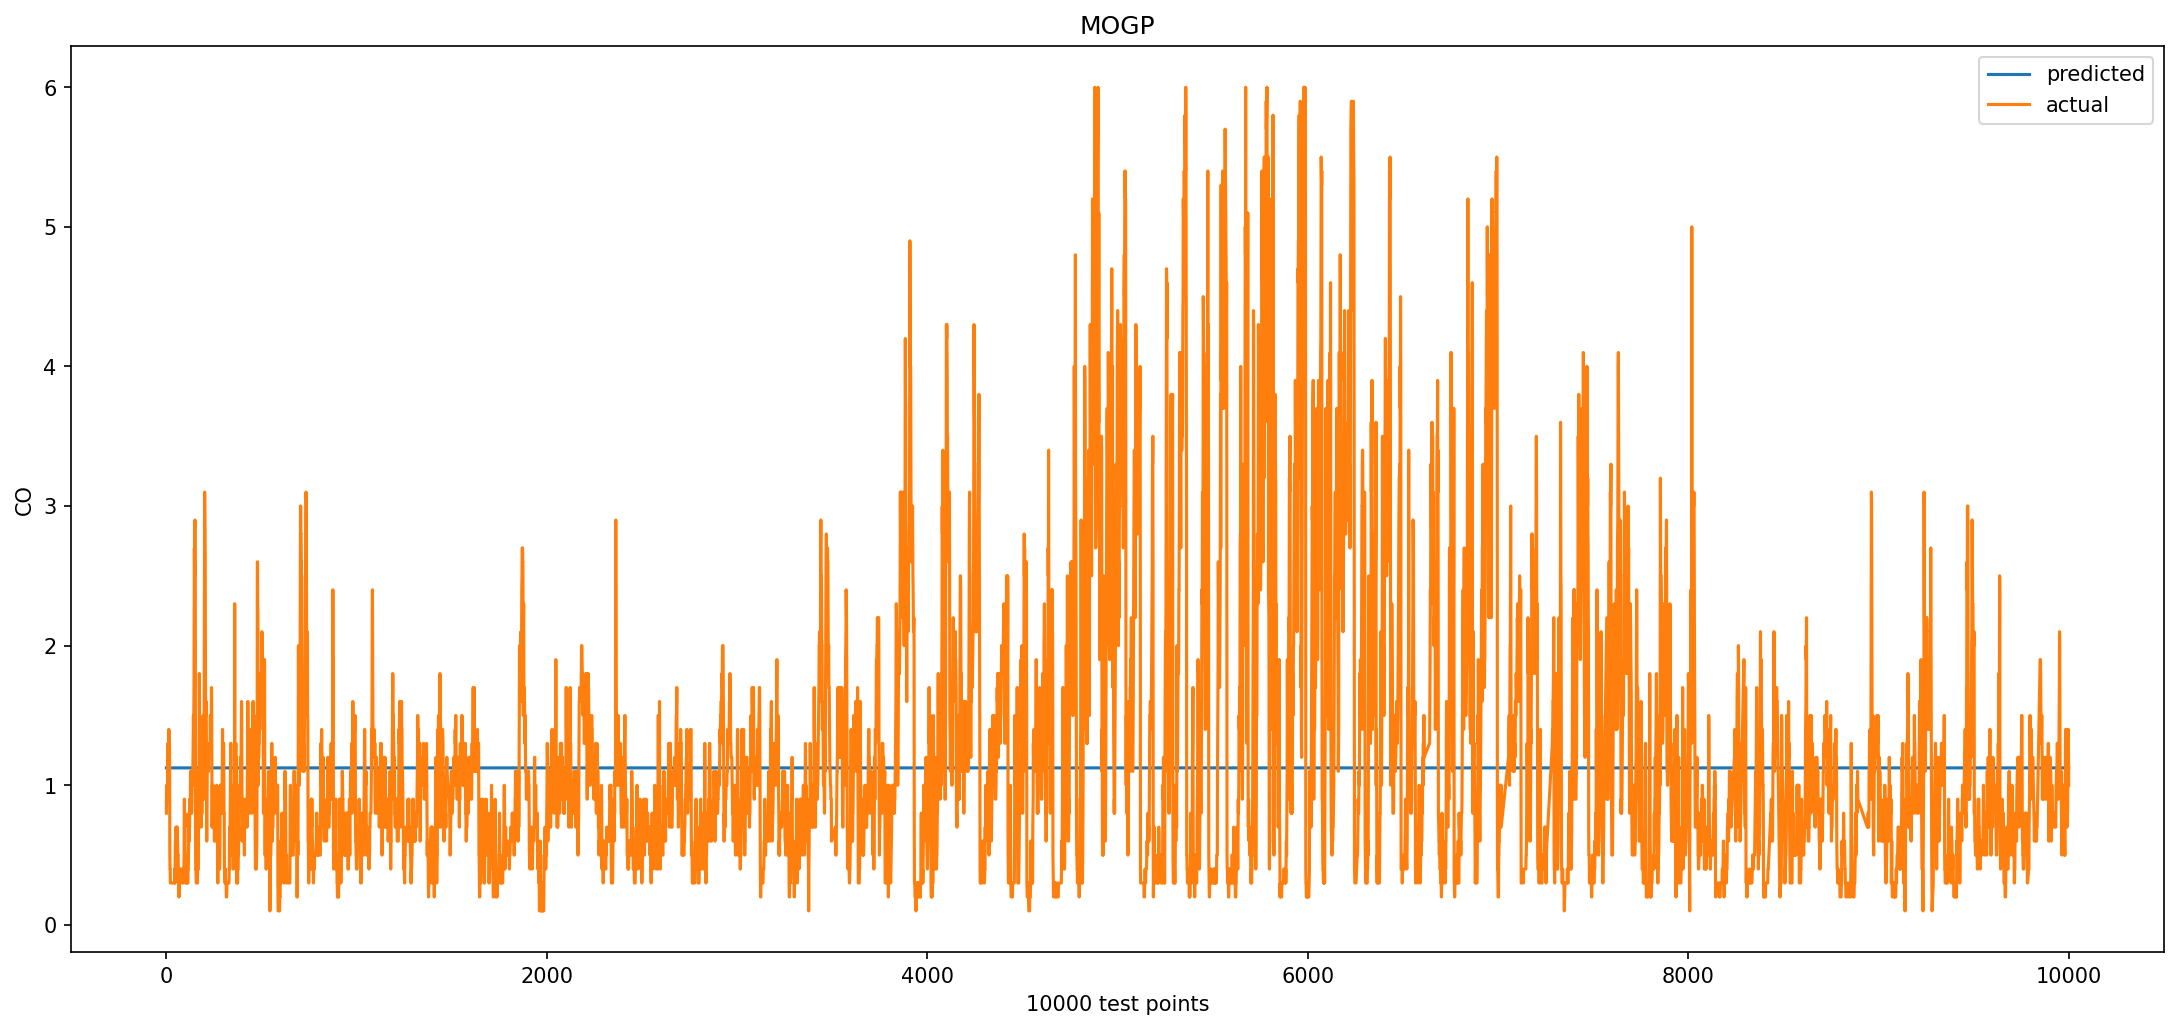

In [33]:

plt.rcParams["figure.dpi"] = 150
fig = plt.figure(figsize=(18, 8))
# plt.fill_between(
#     range(len(test_output[:test_points,:])),
#     lower_line[:,1],
#     upper_line[:,1],
#     facecolor="gray",
#     alpha=0.5,
#     label=r"95% confidence",
# )
plt.plot(mean[:,1], label=r"predicted", linewidth=1.5)
# y_test = test_output[:5000,:]
plt.plot(test_output[:test_points,1], label=r"actual", linewidth=1.5)
plt.ylabel("CO")
plt.legend()
plt.xlabel("10000 test points")
plt.title(
    "MOGP"
)

In [14]:
# # test_dataset = TensorDataset(
# #     torch.tensor(test_input.values).float(), torch.tensor(test_output).float()
# # )
# # test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
# # import math

# # model.eval()
# # observed_pred = model.predict(test_loader)
# # y_test = test_loader.dataset[:][1]

# rmse = mean_squared_error(mean, test_output[:5000,:], squared=False)
# print(f"RMSE: {rmse.item()}")

# msll = gpytorch.metrics.mean_standardized_log_loss(predictions, test_output[:5000,:].to("cuda:1"))
# print(f"MSLL: {msll.mean().item()}")

# nlpd = gpytorch.metrics.negative_log_predictive_density(predictions, test_output[:5000,:].to("cuda:1"))
# print(f"NLPD: {nlpd.mean().item()}")

# coverage_error = gpytorch.metrics.quantile_coverage_error(predictions, test_output[:5000,:].to("cuda:1"))
# print(f"coverage error: {coverage_error.mean().item()}")

In [ ]:
# from scipy.stats import norm
# from math import pi

# def msll(var_pred, y_mean, y_test):
#     f_var = torch.tensor(var_pred)
#     f_mean = torch.tensor(y_mean)
#     return 0.5 * (
#         torch.log(2 * pi * f_var) + torch.square(y_test - f_mean) / (2 * f_var)
#     ).mean(dim=-1)


# def qce(std_pred, y_mean, y_test):
#     quantile = 95.0
#     standard_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
#     deviation = standard_normal.icdf(torch.as_tensor(0.5 + 0.5 * (quantile / 100)))
#     lower = torch.tensor(y_mean) - deviation * std_pred
#     upper = torch.tensor(y_mean) + deviation * std_pred
#     n_samples_within_bounds = ((y_test > lower) * (y_test < upper)).sum(-1)
#     fraction = n_samples_within_bounds / y_test.shape[-1]
#     return torch.abs(fraction - quantile / 100)

In [ ]:
# preds_var = scaler_y.inverse_transform(predictions.variance.detach().cpu())

# msll_ = msll(preds_var, preds_mean, test_output[:test_points,:])
# print(f"MSLL: {msll_.mean()}")

# qce_ = qce(preds_var, preds_mean, test_output[:test_points,:])
# print(f"Coverage Error: {qce_.mean()}")


In [ ]:
# coverage_error = gpytorch.metrics.quantile_coverage_error(predictions, test_output[:5000,:].to("cuda:1"))
# print(f"coverage error: {coverage_error.mean().item()}")

## RF

In [34]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

In [35]:
regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
)
regr_multirf.fit(train_input[:20000,:], mean_train[:20000,:])

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=30,
                                                     random_state=0))

In [36]:
y_multirf = regr_multirf.predict(test_input[:10000,:])

In [37]:
y_multirf[:,0] = scaler_pm.inverse_transform(np.array(y_multirf[:,0]).reshape(-1,1)).reshape(-1,)
y_multirf[:,1] = scaler_co.inverse_transform(y_multirf[:,1].reshape(-1,1)).reshape(-1,)
# lower, upper = predictions.confidence_region()

In [67]:
# err1 = mean_squared_error(y_multirf[:,0], test_output[:test_points,0], squared=False)
# err2 = mean_squared_error(y_multirf[:,1], test_output[:test_points,1], squared=False)
# print(print(f"RMSE: {err1}"))
# print(print(f"RMSE: {err2}"))

In [38]:
print('Test MAE PM: {}'.format(torch.mean(torch.abs(torch.tensor(y_multirf[:,0]) - test_output[:10000,0]))))
print('Test MAE CO: {}'.format(torch.mean(torch.abs(torch.tensor(y_multirf[:,1]) - test_output[:10000,1]))))

Test MAE PM: 53.02469165324465
Test MAE CO: 0.6838937298262184
